- title: "Workflow"
- author: "Margaret Paiva"
- output: Python notebook

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from statistics import median
import gzip
import scipy.io
import scanpy as sc

# Part 1. Load and filter data

In [32]:
######
# data at Amazon S3/Buckets/championsoncology.integration/omics/
######
# The dataset is very large - please don't commit to github
######
filename = "~/Documents/Workspaces/data/S0001_astrocytoma_RAW.txt.gz"
raw = pd.read_csv(filename, compression='gzip', sep='\t', index_col=0)
raw.index = [gene.strip("'") for gene in raw.index]
raw

,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05,MGH42_P7_A07,MGH42_P7_A09,MGH42_P7_A11,MGH42_P7_A12,MGH42_P7_B02,...,MGH107neg_P2_E06,MGH107pos_P2_B03,MGH107neg_P1_F03,MGH107neg_P1_G06,MGH107neg_P2_H03,MGH107neg_P2_C05,MGH107pos_P2_D07,MGH107neg_P1_E01,MGH107pos_P2_G09,MGH107neg_P1_D06
A1BG,1.19280,0.000000,0.00000,0.00000,0.00000,0.66903,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.4772,0.00000,0.0000
A1BG-AS1,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.83996,0.00000,0.0000,0.00000,0.0000
A1CF,0.00000,0.094912,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000
A2M,7.04390,7.609500,0.77062,7.61460,0.00000,0.00000,0.27501,8.16240,6.56550,6.96580,...,0.00000,8.60460,0.00000,0.00000,0.00000,0.00000,9.52810,0.0000,6.89990,0.0000
A2M-AS1,0.00000,0.000000,0.00000,0.00000,2.03390,2.39420,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.00000,0.370720,0.47508,0.15056,0.47508,0.26063,0.15704,0.26664,0.34483,0.24610,...,0.25580,0.13225,0.50080,0.31383,0.50691,0.17505,0.13225,0.9381,0.47301,0.0000
ZYG11B,0.27143,0.444670,3.13260,1.48650,4.03830,2.00580,2.73880,0.70399,0.10299,0.13356,...,0.16864,0.45101,0.20414,0.45733,0.65627,2.94070,0.27739,1.9464,0.48749,4.7947
ZYX,2.70580,2.107700,0.00000,3.84590,3.82720,3.21550,3.23450,3.17860,1.13420,0.43082,...,3.86430,0.00000,0.00000,0.00000,2.66150,0.31383,0.00000,0.0000,0.00000,0.0000
ZZEF1,0.71370,1.143400,0.00000,0.00000,1.55140,1.16220,2.32280,2.37380,0.45312,2.04090,...,0.10702,0.00000,3.08370,2.23760,0.00000,1.03490,0.00000,0.0000,0.00000,1.8969


In [33]:
# start = raw.columns.str.find('_') + 1
# names = [s[i:(i+3)].replace('_', '') for s, i in zip(raw.columns, start)]

## Library size

In [34]:
ls = np.sum(raw, axis=0)  # library size
ls.shape

(6341,)

Text(6.705555555555554, 0.5, 'Frequency')

<Figure size 640x640 with 0 Axes>

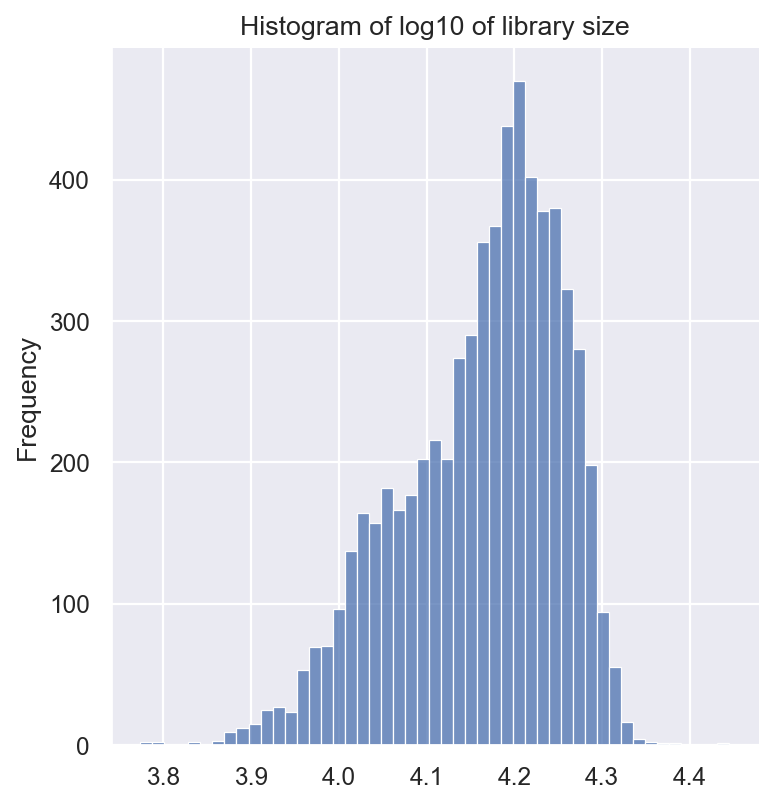

In [35]:
sc.settings.set_figure_params(dpi=80)
sns.set(color_codes=True)

plt.figure(figsize=(8, 8))
sns.displot(np.log10(ls))
plt.title('Histogram of log10 of library size')
plt.ylabel('Frequency')

## Number of cells per gene

In [36]:
num_cells = np.sum(raw>0, axis=1)

# Add 1 to those genes that are expressed in 0 cells for log calculation
num_cells[num_cells==0] = 1  
num_cells.shape

(23686,)

Text(-0.04444444444444606, 0.5, 'Density')

<Figure size 640x640 with 0 Axes>

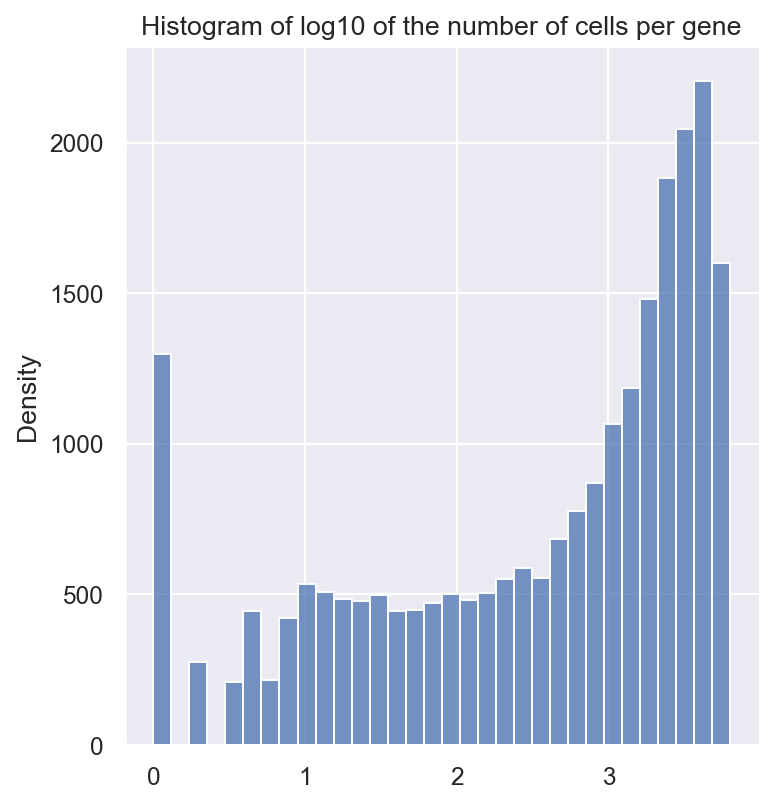

In [37]:
plt.figure(figsize=(8, 8))
sns.displot(np.log10(num_cells))
plt.title('Histogram of log10 of the number of cells per gene')
plt.ylabel('Density')

# Part 2. Normalization

In [38]:
# Convert to AnnData
adata = sc.AnnData(raw.transpose())

# # Add library size as n_counts column
# adata.obs['n_counts'] = np.nansum(raw, axis=0)

adata

AnnData object with n_obs × n_vars = 6341 × 23686

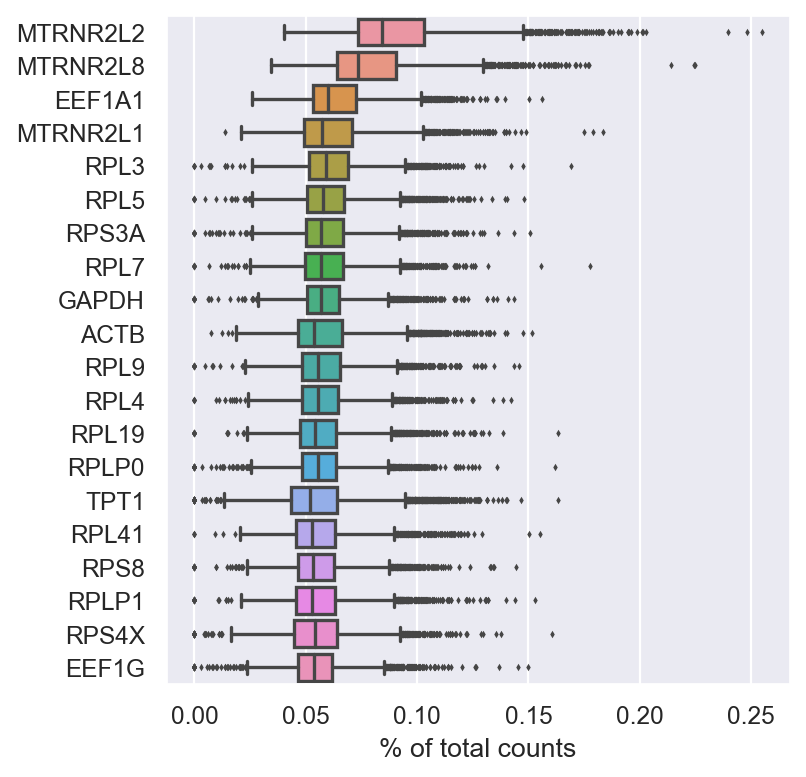

In [39]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [40]:
min_counts = 10**3.8 # keep cells with at least min_counts counts
min_cells = 10**0 # Keep genes that have at least min_cells cells
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_genes(adata, min_cells=min_cells)

adata

AnnData object with n_obs × n_vars = 6337 × 22695
    obs: 'n_counts'
    var: 'n_cells'

In [41]:
# Normalization
sc.pp.normalize_total(adata)

In [42]:
# Double check the normalization result - each cell should have total counts = median_ls
adata.X.sum(axis=1)

array([15126.608, 15126.609, 15126.608, ..., 15126.607, 15126.608,
       15126.609], dtype=float32)

In [43]:
np.any(np.isnan(raw))

False

# Part 3. Dimensionality reduction

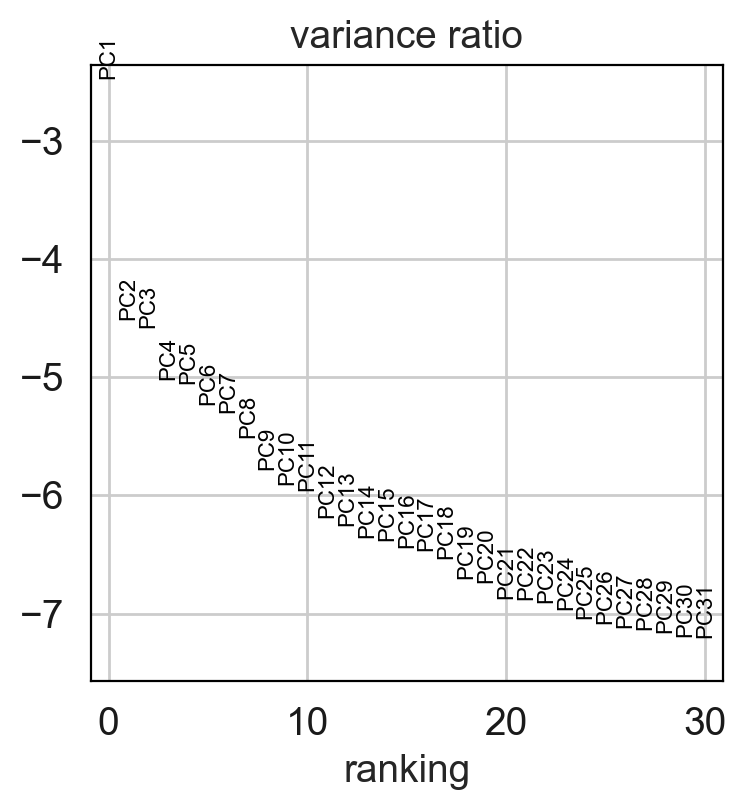

In [44]:
sc.settings.set_figure_params(dpi=100)

sc.pp.log1p(adata)

# Use PCA and decide the number of principle components in Umap
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

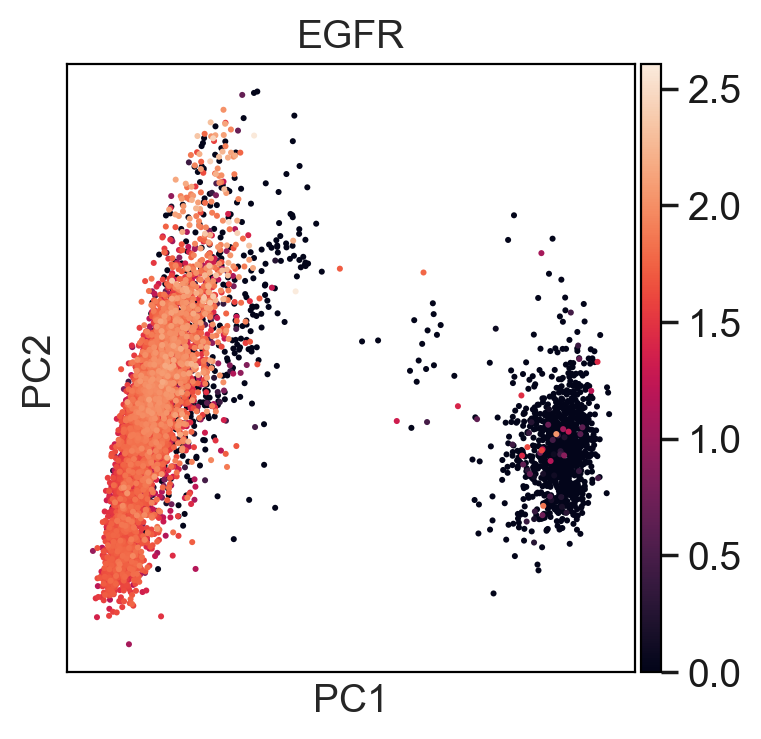

In [45]:
sc.pl.pca(adata, color='EGFR')

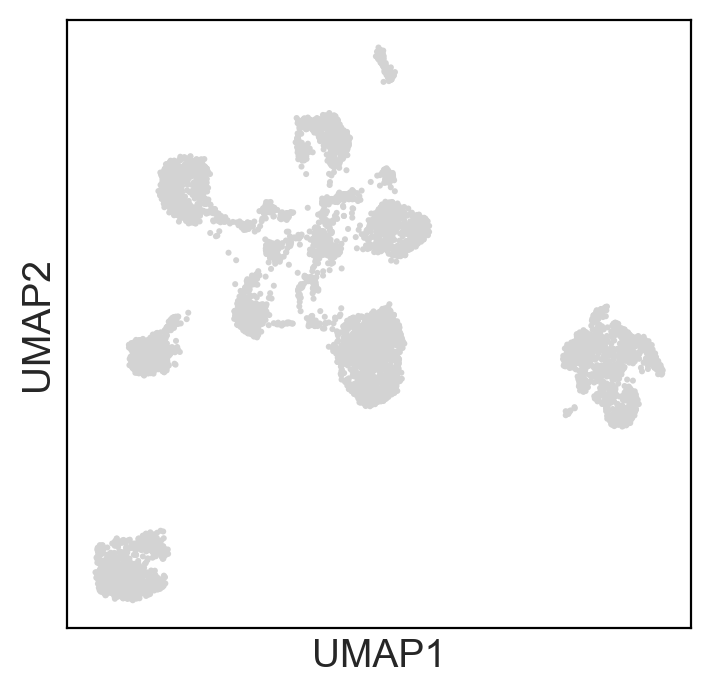

In [46]:
# Based on the figures above, choose the number of principle components
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

# Part 4. Cluster cells based on marker genes

In [47]:
sc.tl.leiden(adata, resolution=0.5)
adata.obs

,n_counts,leiden
MGH42_P7_A01,13181.660156,9
MGH42_P7_A02,12506.630859,9
MGH42_P7_A03,19457.166016,5
MGH42_P7_A04,13993.511719,9
MGH42_P7_A05,17962.277344,5
...,...,...
MGH107neg_P2_C05,15379.042969,8
MGH107pos_P2_D07,8840.265625,2
MGH107neg_P1_E01,14941.124023,8
MGH107pos_P2_G09,8644.626953,2


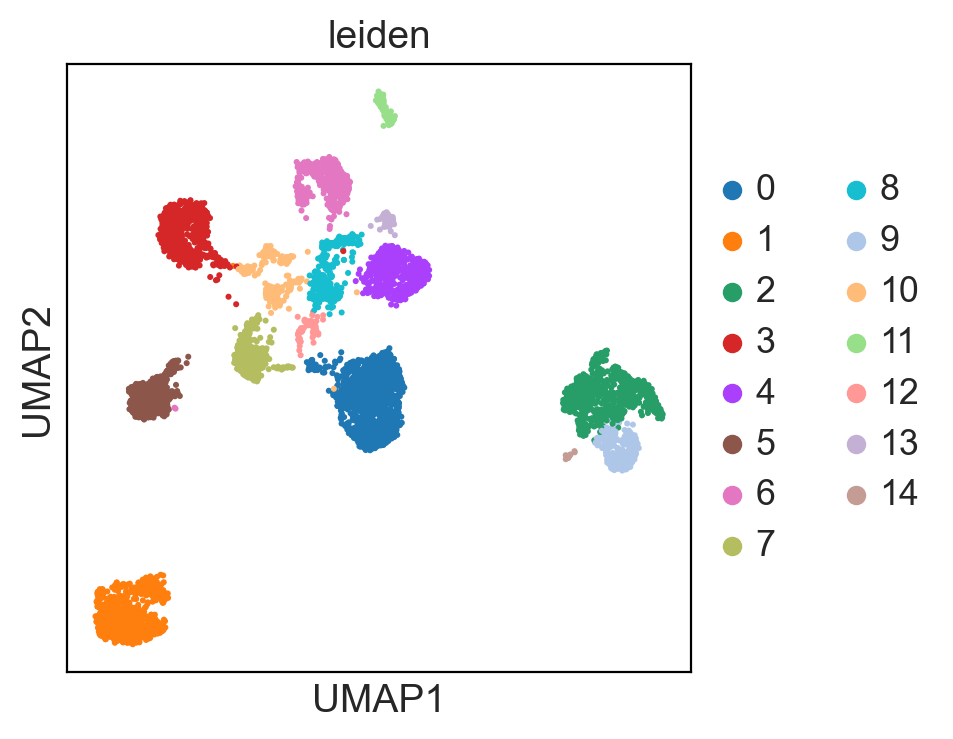

In [48]:
sc.pl.umap(adata, color='leiden')

In [49]:
# start = adata.obs.index.str.find('_') + 1
# adata.obs['batch'] = [s[i:(i+3)].replace('_', '') for s, i in zip(adata.obs.index, start)]
adata.obs['batch'] = adata.obs.index.str[0:6]
adata.obs

,n_counts,leiden,batch
MGH42_P7_A01,13181.660156,9,MGH42_
MGH42_P7_A02,12506.630859,9,MGH42_
MGH42_P7_A03,19457.166016,5,MGH42_
MGH42_P7_A04,13993.511719,9,MGH42_
MGH42_P7_A05,17962.277344,5,MGH42_
...,...,...,...
MGH107neg_P2_C05,15379.042969,8,MGH107
MGH107pos_P2_D07,8840.265625,2,MGH107
MGH107neg_P1_E01,14941.124023,8,MGH107
MGH107pos_P2_G09,8644.626953,2,MGH107


In [50]:
# sc.pl.umap(adata, color='batch')

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


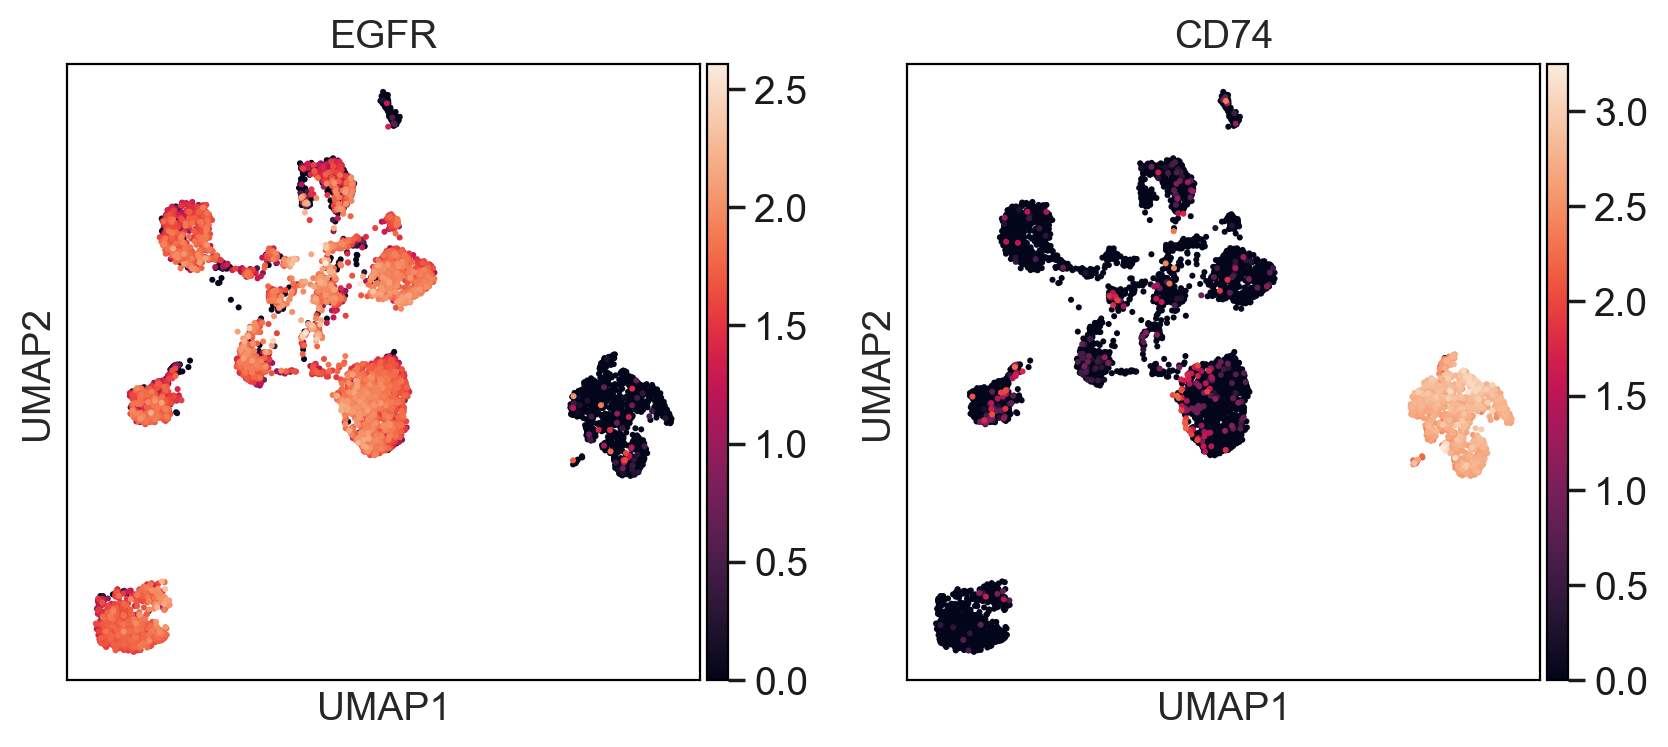

In [51]:
sc.pl.umap(adata, color=['EGFR', 'CD74'])

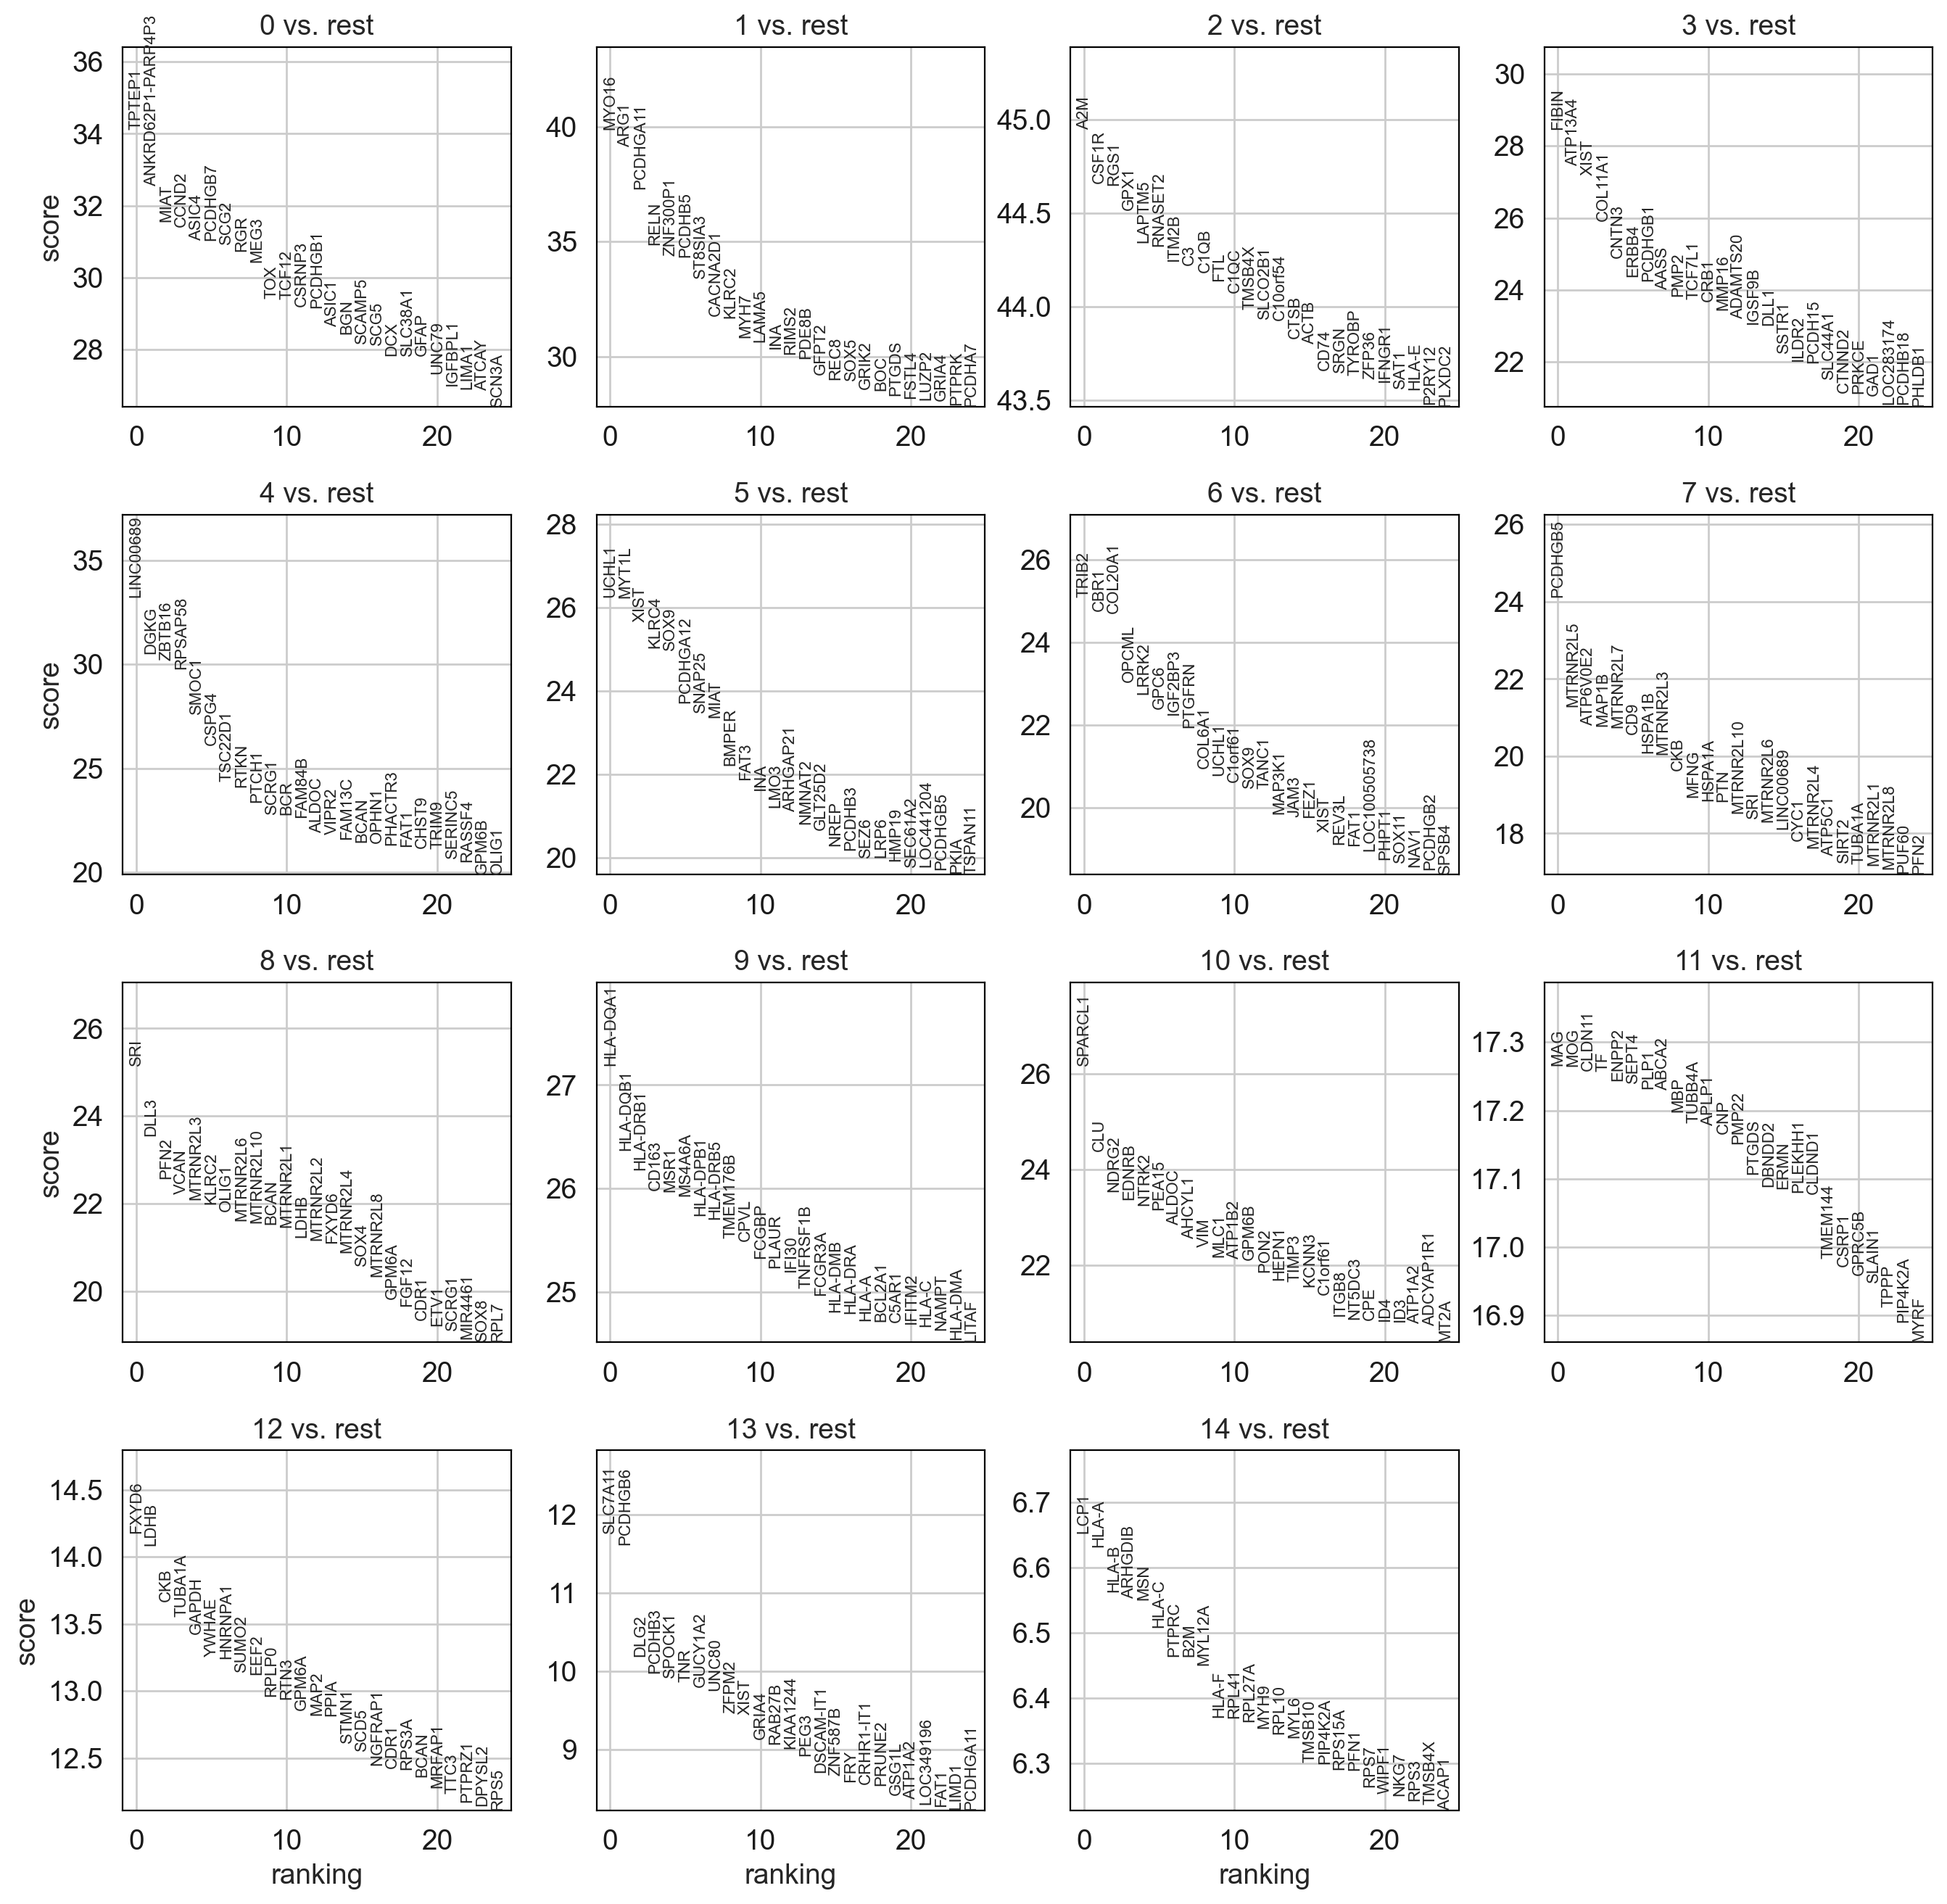

In [52]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

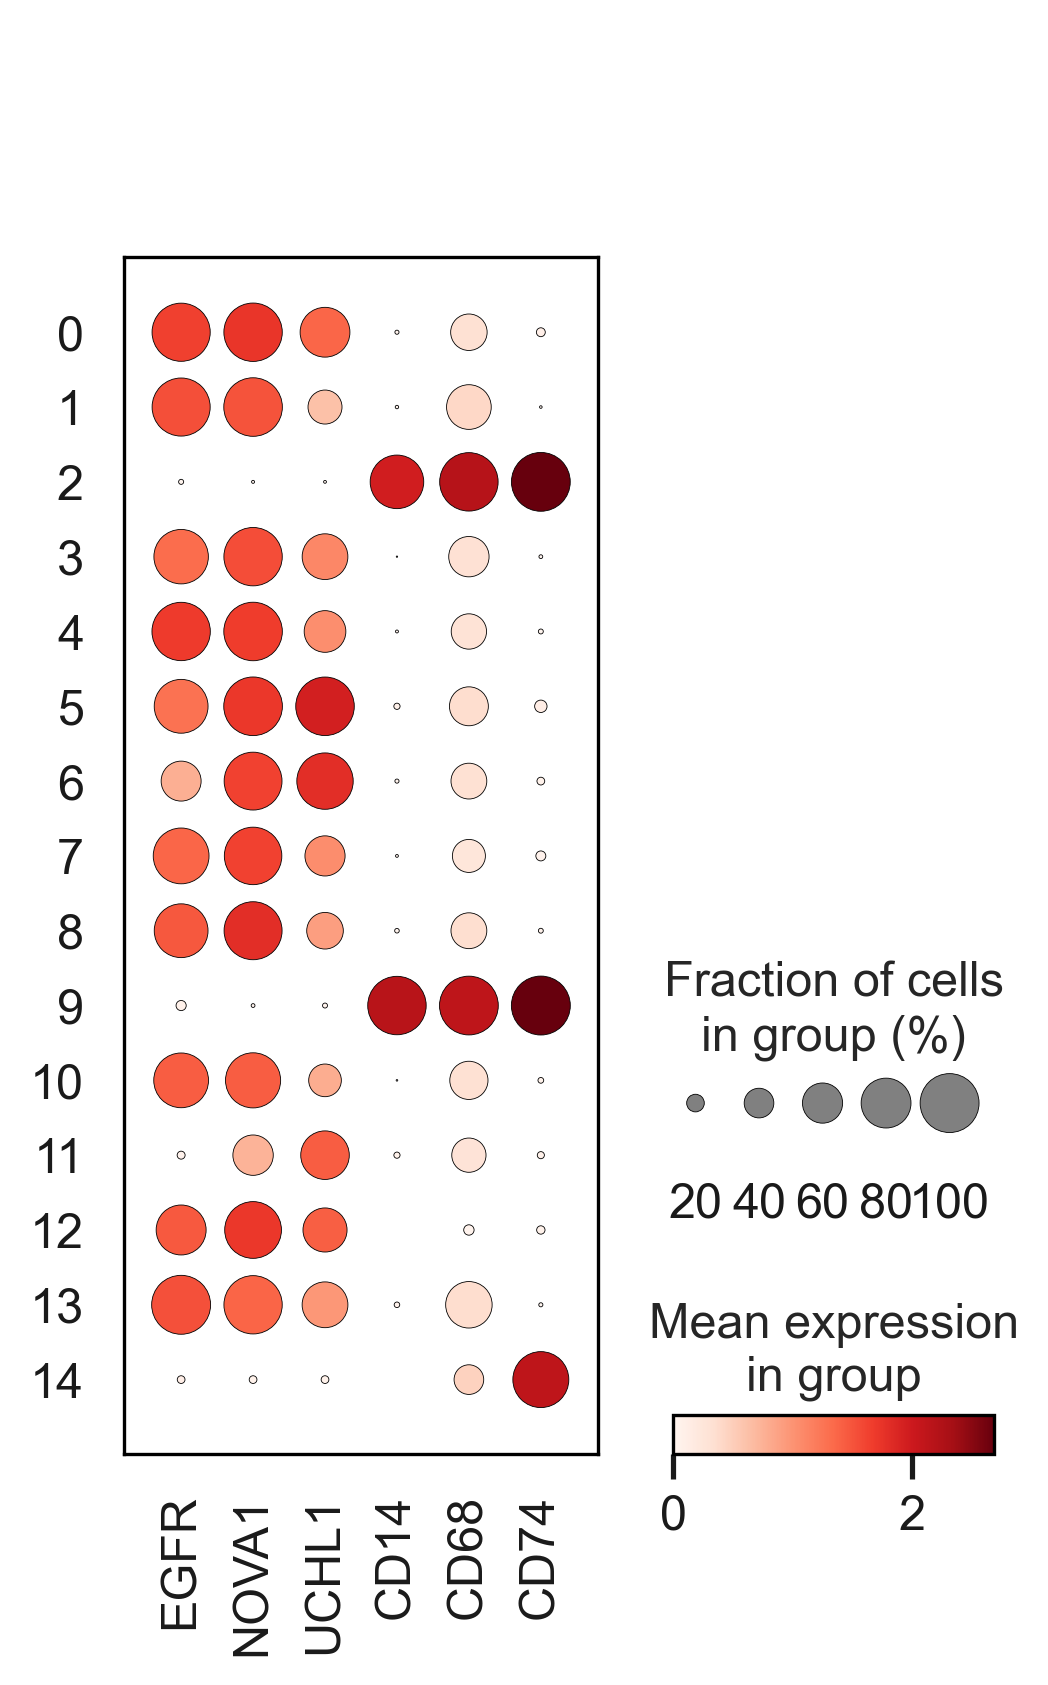

In [53]:
# Decide what marker genes to be marked for each cluster
sc.settings.set_figure_params(dpi=150)
marker_genes = [
                "EGFR", # tumor cell markers
                "NOVA1",  
                "UCHL1",
                "CD14",   # macrophage markers
                "CD68",
                "CD74"
                ]

sc.pl.dotplot(adata, marker_genes, groupby='leiden')

In [54]:
adata

AnnData object with n_obs × n_vars = 6337 × 22695
    obs: 'n_counts', 'leiden', 'batch'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [55]:
adata.obs.leiden

MGH42_P7_A01        9
MGH42_P7_A02        9
MGH42_P7_A03        5
MGH42_P7_A04        9
MGH42_P7_A05        5
                   ..
MGH107neg_P2_C05    8
MGH107pos_P2_D07    2
MGH107neg_P1_E01    8
MGH107pos_P2_G09    2
MGH107neg_P1_D06    8
Name: leiden, Length: 6337, dtype: category
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']

In [56]:
# cluster_names = [
#                  'Transformed1', #0
#                  'Transformed2', #1
#                  'Macrophage1', #2
#                  'Transformed3', #3
#                  'Transformed4', #4
#                  'Transformed5', #5
#                  'Transformed6', #6
#                  'Transformed7', #7
#                  'Transformed8', #8
#                  'Macrophage2', #9
#                  'Transformed9', #10
#                  'Transformed10', #11
#                  'Transformed11', #12
#                  'Transformed12', #13
#                  'Macrophage', #14
#                 ]

cluster_names = [
                 'Tumor P1', #0
                 'Tumor P2', #1
                 'Macrophage 1', #2
                 'Tumor P3', #3
                 'Tumor P4', #4
                 'Tumor P5', #5
                 'Tumor P6', #6
                 'Tumor P7', #7
                 'Tumor P8', #8
                 'Macrophage 2', #9
                 'Tumor P9', #10
                 'Tumor P10', #11
                 'Tumor P11', #12
                 'Tumor P12', #13
                 'Macrophage', #14
                ]

adata.obs['leiden_idx'] = adata.obs.leiden # save the original leiden number
adata.rename_categories('leiden', cluster_names)

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1163: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


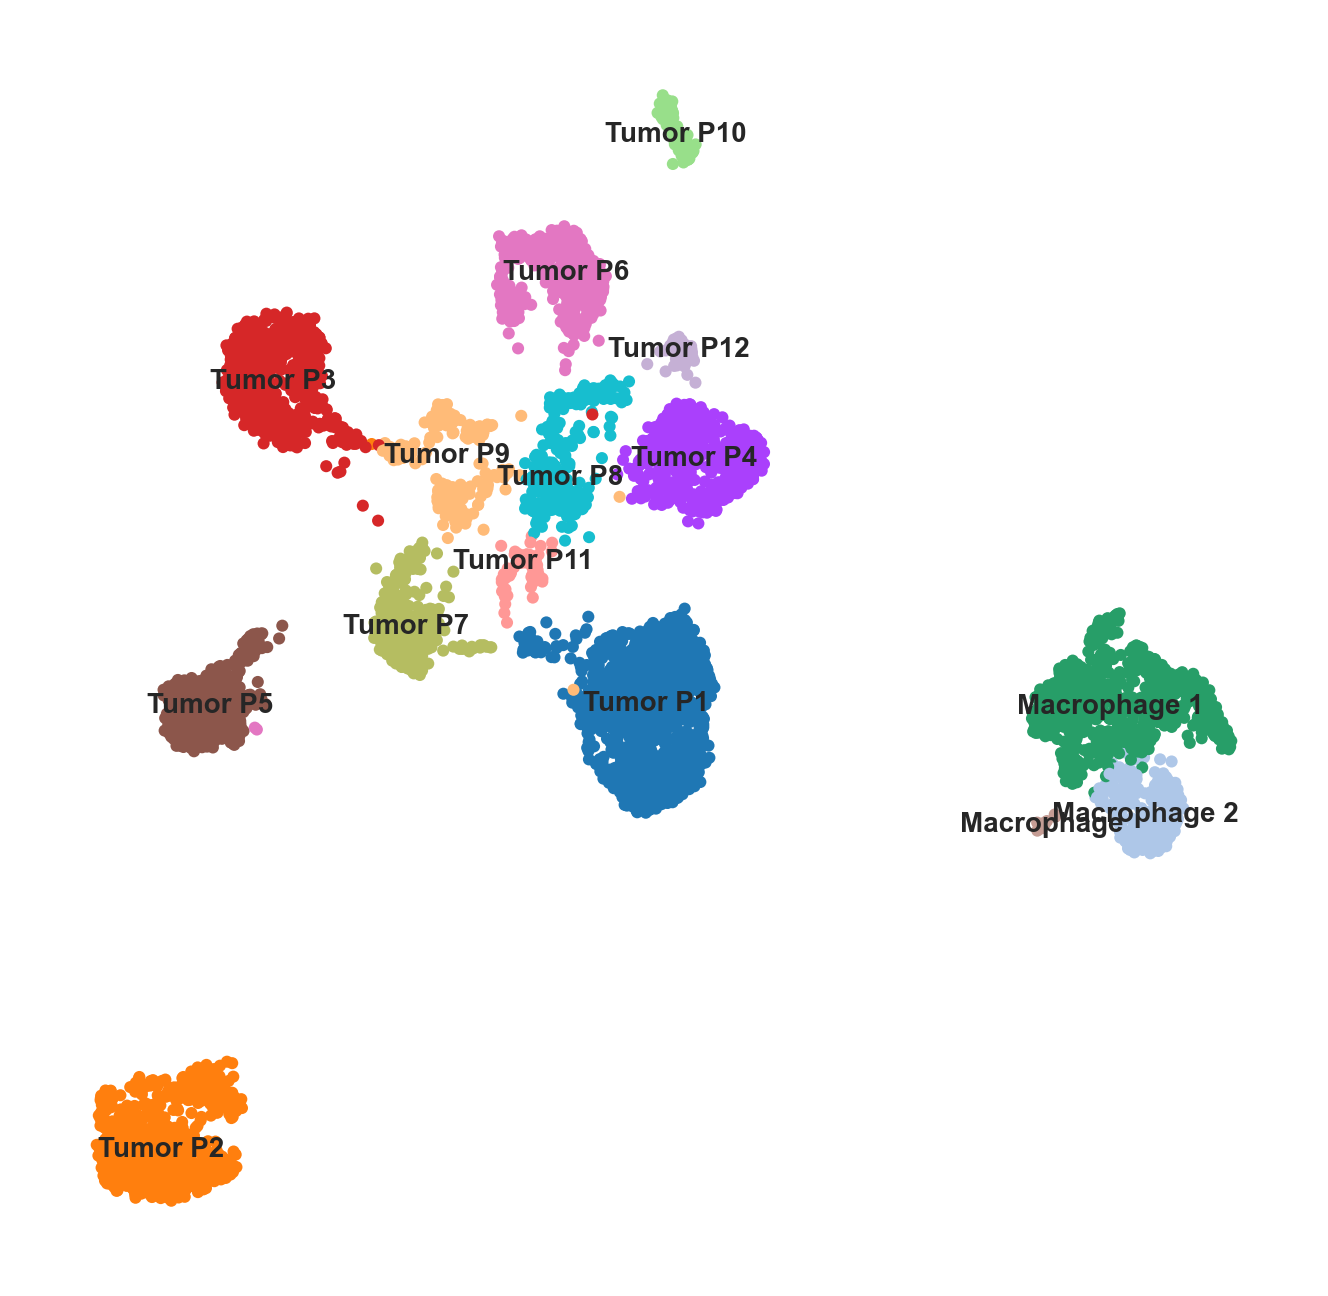

In [57]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color='leiden', legend_loc='on data', 
           title='', legend_fontsize=5, frameon=False)

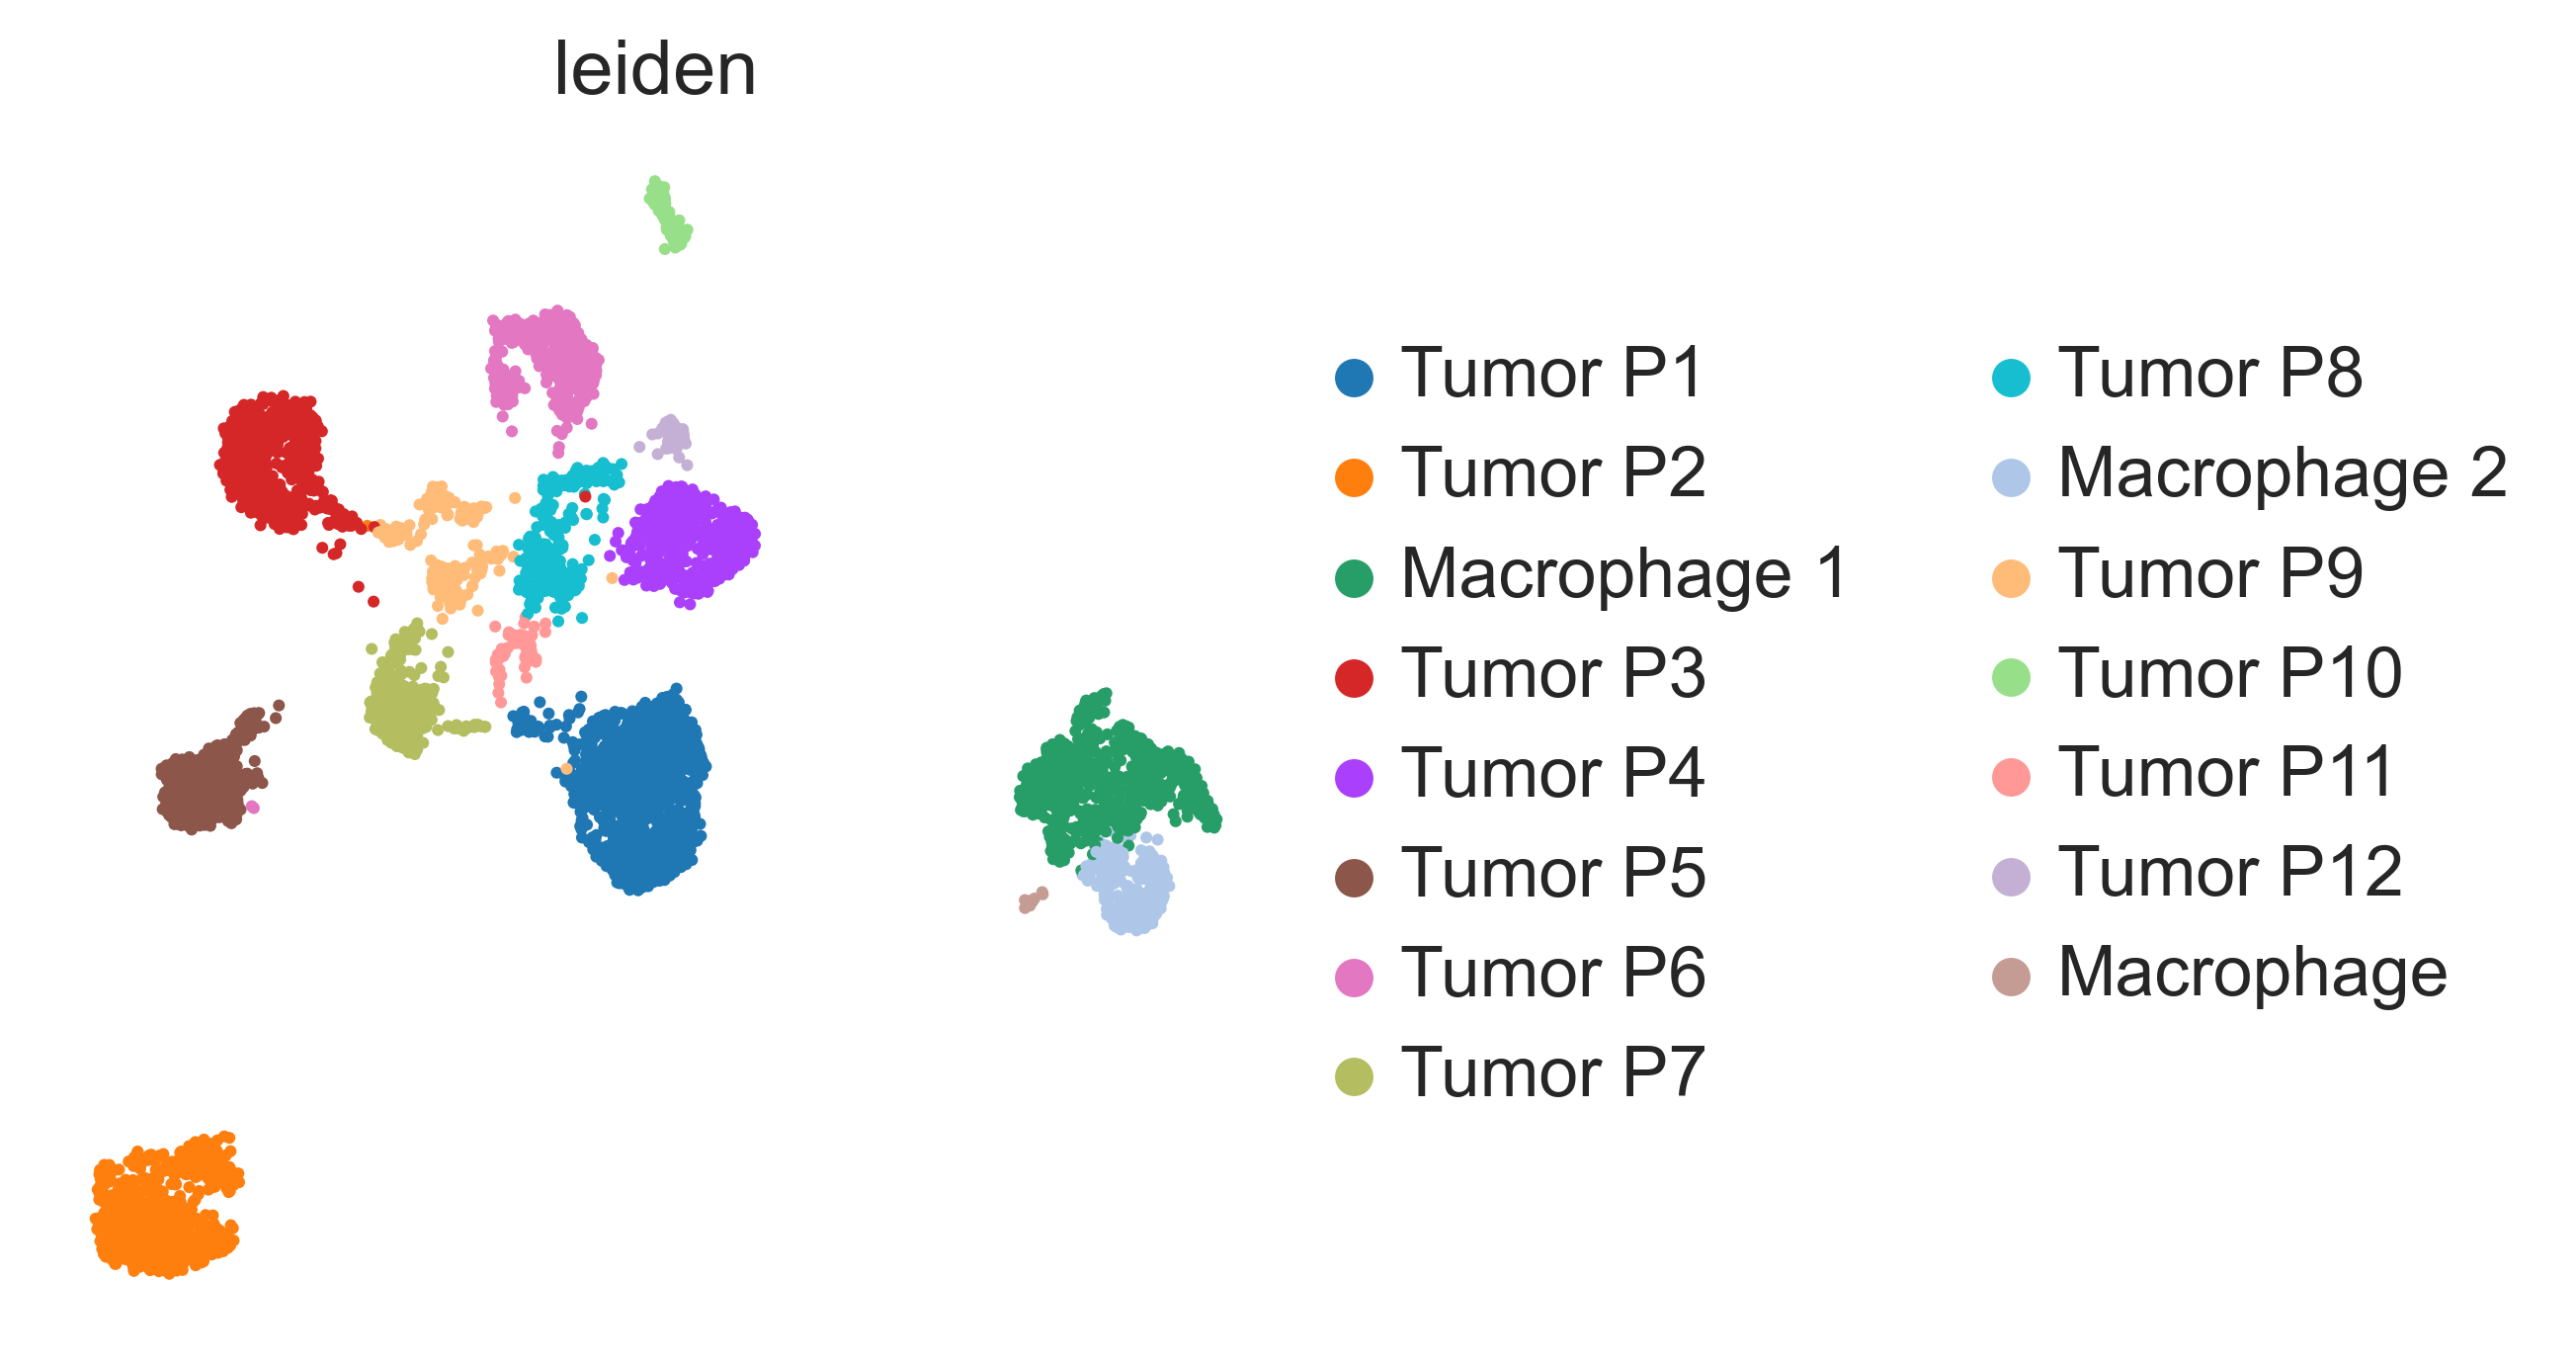

In [61]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color='leiden', ncols=1, frameon=False)

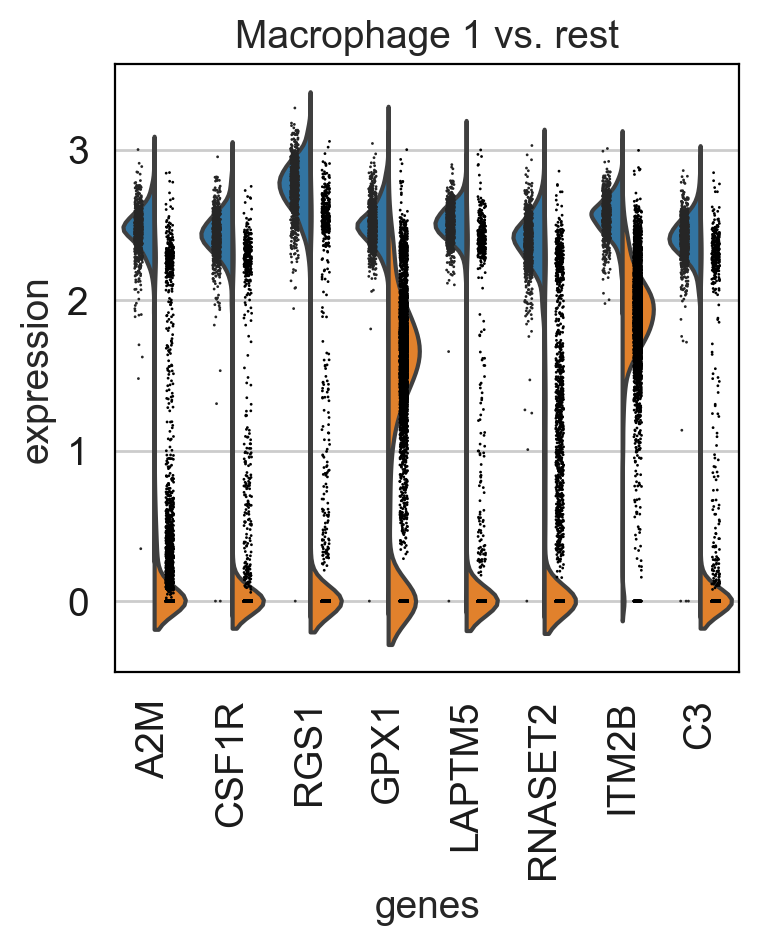

In [59]:
sc.settings.set_figure_params(dpi=100)
sc.pl.rank_genes_groups_violin(adata, groups='Macrophage 1', n_genes=8)

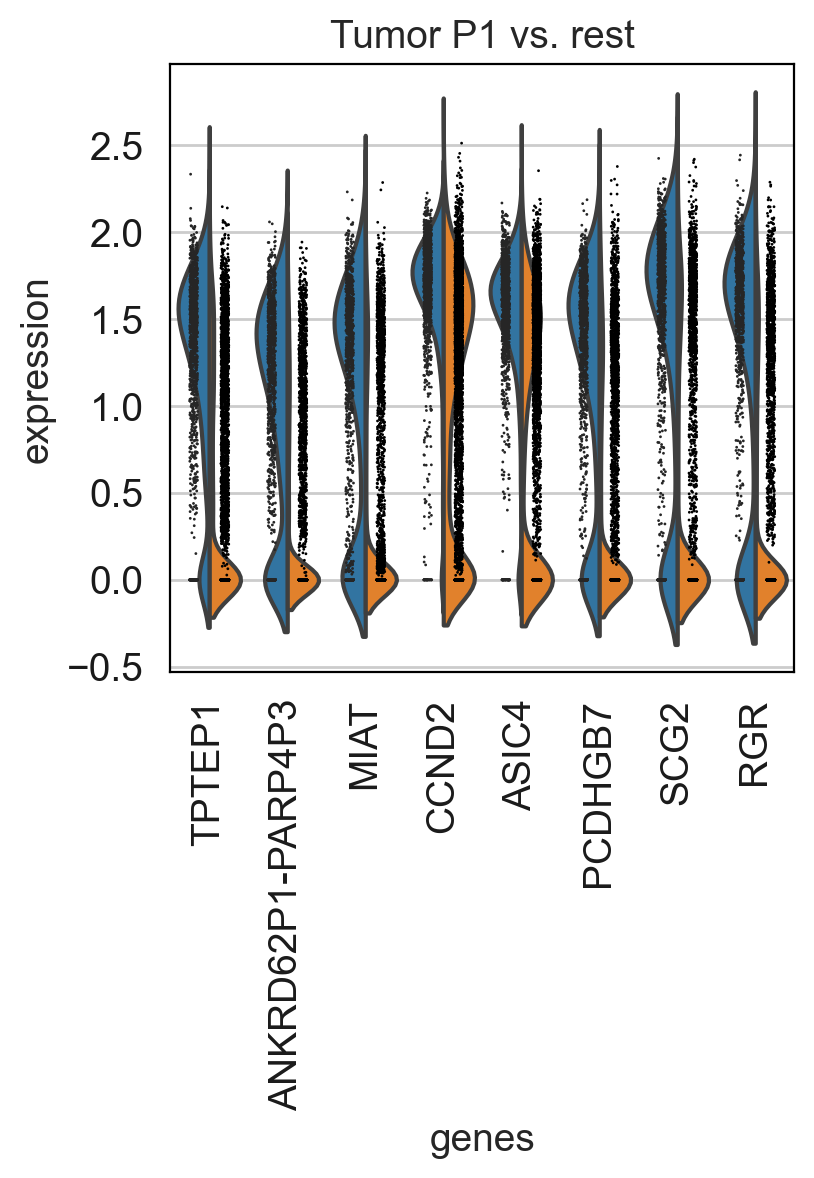

In [60]:
sc.settings.set_figure_params(dpi=100)
sc.pl.rank_genes_groups_violin(adata, groups='Tumor P1', n_genes=8)